In [6]:
import gdal, osr
import numpy as np
from skimage.graph import route_through_array
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os
import math
from osgeo import ogr
import fiona
import jenkspy

## For working with rasters

The Raster files are converted to numpy array for further processing and calculations. 
Raster Properties are stored in RasterProp class.

In [2]:
def raster2array(rasterfn):
    print('converting raster to array...')
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array


class RasterProp:
    def __init__(self,
                 rasterFile,
                 sliceClass=None, slicing = False):
        self.raster = gdal.Open(rasterFile)
        self.geotransform = self.raster.GetGeoTransform()
        self.projRef      = self.raster.GetProjectionRef()
        self.originX = self.geotransform[0]
        self.originY = self.geotransform[3] 
        self.pixelWidth = self.geotransform[1] 
        self.pixelHeight = self.geotransform[5]
        
        if slicing:
            print('recomputing origin')
            x_ori_rel , y_ori_rel, xlen, ylen = sliceClass.relevantArea()
            self.originX, self.originY = pixel2coord(self.geotransform, 
                                                     x_ori_rel, 
                                                     y_ori_rel)
        
def coord2pixelOffset(rasProp,x,y):
    print('coordinate to pixel offsetting...')
    originX = rasProp.originX
    originY = rasProp.originY
    
    pixelWidth = rasProp.pixelWidth 
    pixelHeight = rasProp.pixelHeight

    xOffset = int((x - originX)/pixelWidth)
    yOffset = int((y - originY)/pixelHeight)
    return xOffset,yOffset


def pixel2coord(geoTrans, x, y):
    xoff, a, b, yoff, d, e = geoTrans

    xp = a * x + b * y + a * 0.5 + b * 0.5 + xoff
    yp = d * x + e * y + d * 0.5 + e * 0.5 + yoff
    return(int(xp), int(yp))


def array2raster(array, rasProp,newRasterfn):
    print('converting array to raster...')
    cols = array.shape[1]
    rows = array.shape[0]
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create( newRasterfn, 
                              cols, rows,
                              bands=1, 
                              eType= gdal.GDT_Float32)
    outRaster.SetGeoTransform((rasProp.originX, 
                               rasProp.pixelWidth, 
                               0, rasProp.originY, 
                               0, rasProp.pixelHeight))
    
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(rasProp.projRef)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

## Slicing

---- under development (not required for)-----

To reduce the size of the array files, a slicing of 'relevant' area would be useful. 

In [9]:
class Slicing:
    '''The class used for slicing the data. Doesn't work for all datasets '''
    def __init__(self, rasProp, strPoint, endPoint):
        self.rasProp  = rasProp
        self.strPoint = strPoint
        self.endPoint = endPoint
        
        self.strPix = coord2pixelOffset(self.rasProp, 
                                   self.strPoint[0], 
                                   self.strPoint[1])
        
        self.endPix = coord2pixelOffset(self.rasProp, 
                                   self.endPoint[0],
                                   self.endPoint[1])
        
    def strLineDistance(self):
        
        return int(math.sqrt((self.strPix[0]-self.endPix[0])**2+
                             ((self.strPix[1]-self.endPix[1])**2)))
    
    
    def xydistance(self):
        x_width = abs(self.strPix[0]-self.endPix[0])
        y_width = abs(self.strPix[1]-self.endPix[1]) 
        return x_width, y_width 
    
    
    def relevantArea(self, xMargin=1.2, yMargin=1.2):
        strDist = self.strLineDistance()
        xWidth , yWidth = self.xydistance()
        #xWidth = xWidth*xMargin
        #yWidth = yWidth*yMargin
        
        x_ori_rel = int(self.strPix[0] - strDist/5)
        y_ori_rel = int(self.strPix[1] - strDist/5)
        
        selAreax_w = int(xWidth+2*strDist/5)
        selAreay_w = int(yWidth+2*strDist/5)
        if x_ori_rel < 0:
            x_ori_rel = 0

        if y_ori_rel < 0:
            y_ori_rel = 0
            
        #if selAreay_w < 0:
        #    y_ori_rel =

        print('relevant area slice:x_ori,x_width,y_orig,y_width', 
              x_ori_rel, selAreax_w, y_ori_rel, selAreay_w)
        
        return x_ori_rel, y_ori_rel, selAreax_w, selAreay_w


def array2raster_slice(array, sliceClass,
                       rasProp, newRasterfn):
    print('converting slice array to raster...')
    cols = array.shape[1]
    rows = array.shape[0]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, 
                              cols, rows, 
                              gdal.gdal.GDT_Float32)
    x_ori_rel , y_ori_rel, xlen, ylen = sliceClass.relevantArea()
    x_origin, y_origin = pixel2coord(rasProp, x_ori_rel, y_ori_rel)
    
    outRaster.SetGeoTransform((x_origin, 
                               rasProp.pixelWidth, 
                               0, y_origin, 
                               0, rasProp.pixelHeight))
    
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(rasProp.projRef)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [11]:
def shapeTestAll(factorPaths):
    for factor in factorPaths:
        print(np.shape(raster2array(factor)))

# Data Preparation

## Jenks Natural Breaks Classification

Jenks Natural breaks classification algorithm is used to classify the **elevation**, **population**, and **slope** data. https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization

This is required because simple normalization would significantly undervalue the data because of extreme peaks. 

The data has been broken into 10 clusters with values mapped between 0 to 10. 

Since jenks classification algorithm is very time consuming, it is not possible to run it on the entire dataset to compute the breaks. Hence, the breaks have been calculted based on a random sample of the original data. The size of the random sample is 100000.

Running this again would create (slightly) different breaks and hence to reproduce the results it is not recommended to the classification again.

In [3]:
elevPathOri = os.path.abspath('01_Data500/elevation.tif')
popuPathOri = os.path.abspath('01_Data500/population.tif')
slopPathOri = os.path.abspath('01_Data500/slope.tif')

In [32]:
def jenks_classify(originalRaster, outRaster, sampleSize=1000):
    array = raster2array(originalRaster)
    print('array created...')
    array[np.isnan(array)]=0
    array_f = array.ravel()
    print('finding breaks...')
    array_sam = np.random.choice(array_f, size=sampleSize, replace=False)
    breaks = jenkspy.jenks_breaks(array_sam, nb_class=9)
    print(breaks)
    print('digitizing...')
    array_f_dig = np.digitize(array_f, breaks).astype(float)
    array_dig = np.reshape(array_f_dig, np.shape(array))
    array2raster(array_dig, RasterProp(originalRaster), outRaster)
    return array_dig

In [33]:
#jenks_classify(elevPathOri, os.path.abspath('01_Data500/elevation_jc.tif'))

converting raster to array...
array created...
finding breaks...
[-6.445716857910156, 54.97124099731445, 173.21983337402344, 320.7486267089844, 515.2106323242188, 732.7840576171875, 970.2399291992188, 1291.229248046875, 1711.7459716796875, 2228.373046875]
digitizing...
converting array to raster...


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [22]:
#jenks_classify(popuPathOri, os.path.abspath('01_Data500/population_jc.tif'))

converting raster to array...
array created...
finding breaks...
[0.0, 7.0, 30.0, 66.0, 103.0, 154.0, 220.0, 334.0, 471.0, 1507.0, 3339.0]
digitizing...
converting array to raster...


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [23]:
#jenks_classify(slopPathOri, os.path.abspath('01_Data500/slope_jc.tif'))

converting raster to array...
array created...
finding breaks...
[0.0, 0.6363528966903687, 1.9423604011535645, 3.4714224338531494, 5.077847957611084, 8.066366195678711, 10.374420166015625, 14.328324317932129, 18.270305633544922, 23.45761489868164, 29.169322967529297]
digitizing...
converting array to raster...


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

## Calculation of total cost raster

In [38]:
def createTotalCostRaster(factorPathList, 
                          weightList, 
                          rasProp,
                          rasterName, 
                          slicing=False, 
                          strPoint=None, 
                          endPoint=None):
    
    if not slicing:
        #print(factorNames[0])
        costArray = maxMinScale(raster2array(factorPathList[0]))*weightList[0]
        costArray[np.isnan(costArray)]=0
        
        for fpos in range(1,len(factorPathList)):
            #print(factorNames[fpos])
            factorArray = maxMinScale(raster2array(factorPathList[fpos]))*weightList[fpos]
            factorArray[np.isnan(factorArray)]=0
            #plt.imshow(factorArray)
            costArray = np.add(costArray, factorArray)
        costArray[np.isnan(costArray)]=0
        plt.imshow(costArray)
        plt.colorbar()
        array2raster(costArray, rasProp, rasterName)
        return costArray, rasProp
    
    
    else:
        sliceObj = Slicing(rasProp, strPoint, endPoint)
        raster = gdal.Open(factorPathList[0])
        band   = raster.GetRasterBand(1)
        
        x_ori_rel , y_ori_rel, xlen, ylen = sliceObj.relevantArea()
        
        sliceRasProp = RasterProp(factorPathList[0],
                                  slicing   = True, 
                                  sliceClass= sliceObj)
        
        array = band.ReadAsArray(xoff=x_ori_rel, 
                          yoff=y_ori_rel,
                          win_xsize=xlen,
                          win_ysize=ylen
                         )
        
        costArray = maxMinScale(array)*weightList[0]
        
        for fpos in range(1, len(factorPathList)):
            raster = gdal.Open(factorPathList[fpos])
            band   = raster.GetRasterBand(1)
            factorArray = maxMinScale(band.ReadAsArray(xoff=x_ori_rel, 
                          yoff=y_ori_rel,
                          win_xsize=xlen,
                          win_ysize=ylen
                         ))*weightList[fpos]
            
            costArray = np.add(costArray, factorArray)
        
        np.place(costArray, costArray==nan,0)
        array2raster(costArray, sliceRasProp, rasterName)
        plt.imshow(costArray)
        return costArray, sliceRasProp

    

#getStartEndCord(dc1)

In [40]:
def maxMinScale(array):
    return (array/abs(array.max()-array.min()))

In [36]:
corePath = os.path.abspath('01_Data500/corine.tif')
elevPath = os.path.abspath('01_Data500/elevation_jc.tif')
gridPath = os.path.abspath('01_Data500/grid_pos.tif')
popuPath = os.path.abspath('01_Data500/population_jc.tif')
protPath = os.path.abspath('01_Data500/protected.tif')
railPath = os.path.abspath('01_Data500/rails_pos.tif')
rivePath = os.path.abspath('01_Data500/river.tif')
roadPath = os.path.abspath('01_Data500/roads_pos.tif')
slopPath = os.path.abspath('01_Data500/slope_jc.tif')
seaPath  = os.path.abspath('01_Data500/sea.tif')

In [6]:
factorPaths = [
             corePath,
    elevPath,
    gridPath,
    popuPath,
    protPath,
    railPath,
    rivePath,
    roadPath,
    slopPath,
    seaPath
            ]

factorWeights = [
                1,#corine
                1,#elevation
                1,#grid
                1,#population
                1,#protected
                1,#rails
                1,#river
                1,#roads
                1,#slope
                10#deepsea
                ]

factorNames = [
    'Corine',
    'elevation',
    'grid',
    'population',
    'protected',
    'rails',
    'river',
    'roads',
    'slope',
    'sea'
]

# Rasters grouped to four factors of analysis

add description

## Economic Factors

eco factor raster, weigths =0.5, 0.5 because 2 factors

when considering only slope weight = 1.0

converting raster to array...
converting array to raster...


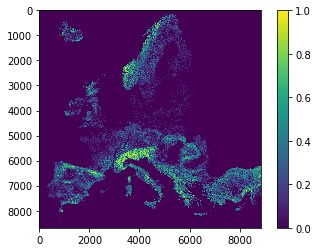

In [41]:
ecoFac = [slopPath]
ecoFacRaster = os.path.abspath('01_Data500/fac_eco_onlySlope.tif')
ecoArray, ecoProp =   createTotalCostRaster(factorPathList=ecoFac, weightList=[1], 
                      rasProp = RasterProp(corePath), rasterName = ecoFacRaster)

## Environmental Factors

env factors rasters, weights =0.33,0.33,0.33 because 3

converting raster to array...
converting raster to array...
converting raster to array...
converting array to raster...


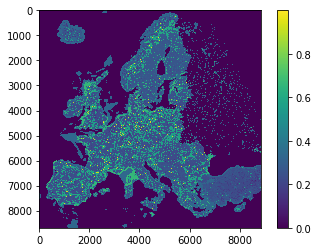

In [42]:
envFac = [corePath, rivePath, protPath]
envFacRaster = os.path.abspath('01_Data500/fac_env.tif')
envArray, envProp =   createTotalCostRaster(factorPathList=envFac, 
                                            weightList=[0.333,0.333,0.333], 
                                            rasProp = RasterProp(corePath), 
                                            rasterName = envFacRaster)

## Population Factor 

converting raster to array...
converting array to raster...


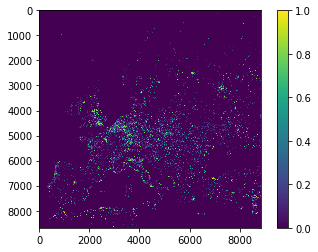

In [43]:
pubFac = [popuPath]
pubFacRaster = os.path.abspath('01_Data500/fac_pub.tif')
pubArray, pubProp =   createTotalCostRaster(factorPathList=pubFac, weightList=[1], 
                    rasProp = RasterProp(popuPath), rasterName = pubFacRaster)

## Infra Factor

converting raster to array...
converting raster to array...
converting raster to array...
converting array to raster...


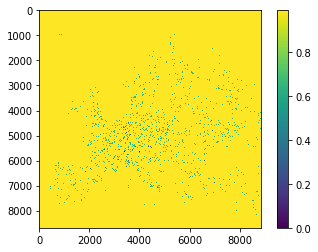

In [44]:
infFac = [gridPath, roadPath, railPath]
infFacRaster = os.path.abspath('01_Data500/fac_inf.tif')
infArray, infProp =   createTotalCostRaster(factorPathList=infFac, 
                                          weightList=[0.33,0.33,0.33], 
                    rasProp = RasterProp(railPath), rasterName = infFacRaster)

## City Area

In [34]:
corOriPath = os.path.abspath('01_Data500/corine_500_original_classification.tif')
cityPath = os.path.abspath('01_Data500/city.tif')


def createCityRaster(cityValue):
    corAre = raster2array(corOriPath)
    cityAr = corAre.copy()
    cityAr[np.isin(corAre, [1,2,3,10,11,7])] =cityValue
    print(cityAr)
    cityAr[np.isin(corAre, [1,2,3,10,11,7], invert=True)]=0
    print(cityAr)
    array2raster(cityAr,RasterProp(corOriPath),cityPath)
    return cityAr

# Calculation of Path

In [10]:
def createPath(rasProp, costSurfaceArray,
               startCoord,stopCoord):
    '''returns an array of the same shape as costSurfaceArray with
    1 for path and 0 for other cells'''
    print('creating path...')
    # coordinates to array index
    startCoordX = startCoord[0]
    startCoordY = startCoord[1]
    startIndexX,startIndexY = coord2pixelOffset(rasProp,
                                                startCoordX,
                                                startCoordY)

    stopCoordX = stopCoord[0]
    stopCoordY = stopCoord[1]
    stopIndexX,stopIndexY = coord2pixelOffset(rasProp,
                                              stopCoordX,stopCoordY)
    # create path
    indices, weight = route_through_array(costSurfaceArray, 
                                          (startIndexY,startIndexX), 
                                          (stopIndexY,stopIndexX),
                                          geometric=True,
                                          fully_connected=True)
    
    
    indices = np.array(indices).T
    path = np.zeros_like(costSurfaceArray)
    path[indices[0], indices[1]] = 1
    print('path created...')
    return path

### For German Planned DC Projects

In [9]:
def getStartEndCord(file):
    '''For reading 'start' and 'end' coordindates from shape files - 
    used specifically for DC connection files'''
    
    shape = fiona.open(file)
    first = shape.next()
    strX, strY =first.get('properties').get('CoordX'), first.get('properties').get('CoordY')
    second = shape.next()
    endX, endY =second.get('properties').get('CoordX'), second.get('properties').get('CoordY')
    #return first
    return ((strX,strY) ,(endX,endY))


def writePath(costArray, dc, pathName):
    '''Calculating and writing path for DC Connections'''
    path = createPath(RasterProp(ecoFacRaster), costArray, 
                       getStartEndCord(dc)[0],  getStartEndCord(dc)[1])
    array2raster(path, RasterProp(ecoFacRaster), pathName)
    

In [7]:
dcProjects = os.path.abspath('02_DC_Projects_DE//')
dc1 = str(dcProjects+'\\DC_1.shp')
dc2 = str(dcProjects+'\\DC_2.shp')
dc3 = str(dcProjects+'\\DC_3.shp')
dc4 = str(dcProjects+'\\DC_4.shp')
dc5 = str(dcProjects+'\\DC_5.shp')
dc_de_path = [dc1,dc2,dc3,dc4,dc5]
dc_de_name = ['dc1','dc2','dc3','dc4','dc5']

## Path for German Planned DCs

### Loading cost rasters

In [26]:
ecoPath  = os.path.abspath('01_Data500/fac_eco_onlySlope.tif')
ecoArray = raster2array(ecoPath)
envPath  = os.path.abspath('01_Data500/fac_env.tif')
envArray = raster2array(envPath)
infPath  = os.path.abspath('01_Data500/fac_inf.tif')
infArray = raster2array(infPath)
pubPath  = os.path.abspath('01_Data500/fac_pub.tif')
pubArray = raster2array(pubPath)
allArray = (ecoArray+envArray+infArray+pubArray)/4

converting raster to array...
converting raster to array...
converting raster to array...
converting raster to array...


### Calculating paths for each DCs

In [37]:
writePath(ecoArray, dc1, os.path.abspath('01_Data500/out/eco_dc1.tif'))
writePath(envArray, dc1, os.path.abspath('01_Data500/out/env_dc1.tif'))
writePath(infArray, dc1, os.path.abspath('01_Data500/out/inf_dc1.tif'))
writePath(pubArray, dc1, os.path.abspath('01_Data500/out/pub_dc1.tif'))
writePath(allArray, dc1, 
          os.path.abspath('01_Data500/out/all_dc1.tif'))

C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


In [38]:
writePath(ecoArray, dc2, os.path.abspath('01_Data500/out/eco_dc2.tif'))
writePath(envArray, dc2, os.path.abspath('01_Data500/out/env_dc2.tif'))
writePath(infArray, dc2, os.path.abspath('01_Data500/out/inf_dc2.tif'))
writePath(pubArray, dc2, os.path.abspath('01_Data500/out/pub_dc2.tif'))
writePath(allArray, dc2, 
          os.path.abspath('01_Data500/out/all_dc2.tif'))

C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


In [39]:
writePath(ecoArray, dc3, os.path.abspath('01_Data500/out/eco_dc3.tif'))
writePath(envArray, dc3, os.path.abspath('01_Data500/out/env_dc3.tif'))
writePath(infArray, dc3, os.path.abspath('01_Data500/out/inf_dc3.tif'))
writePath(pubArray, dc3, os.path.abspath('01_Data500/out/pub_dc3.tif'))
writePath(allArray, dc3, 
          os.path.abspath('01_Data500/out/all_dc3.tif'))

C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


In [40]:
writePath(ecoArray, dc4, os.path.abspath('01_Data500/out/eco_dc4.tif'))
writePath(envArray, dc4, os.path.abspath('01_Data500/out/env_dc4.tif'))
writePath(infArray, dc4, os.path.abspath('01_Data500/out/inf_dc4.tif'))
writePath(pubArray, dc4, os.path.abspath('01_Data500/out/pub_dc4.tif'))
writePath(allArray, dc4, 
          os.path.abspath('01_Data500/out/all_dc4.tif'))

C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


In [41]:
writePath(ecoArray, dc5, os.path.abspath('01_Data500/out/eco_dc5.tif'))
writePath(envArray, dc5, os.path.abspath('01_Data500/out/env_dc5.tif'))
writePath(infArray, dc5, os.path.abspath('01_Data500/out/inf_dc5.tif'))
writePath(pubArray, dc5, os.path.abspath('01_Data500/out/pub_dc5.tif'))
writePath(allArray, dc5, 
          os.path.abspath('01_Data500/out/all_dc5.tif'))

C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


# ------ Legacy code ------

In [ ]:
for dcNum in range(0,5,1):
    writePath(ecoArray, dc_de_path[dcNum], 
              os.path.abspath(str('01_Data500/out/eco_' + dc_de_name[dcNum]+'.tif')))

In [119]:
writePath(ecoArray, dc4, os.path.abspath('01_Data500/out/eco_dc4.tif'))
writePath(envArray, dc4, os.path.abspath('01_Data500/out/env_dc4.tif'))
writePath(infArr,   dc4, os.path.abspath('01_Data500/out/inf_dc4.tif'))
writePath(pubArr,   dc4, os.path.abspath('01_Data500/out/pub_dc4.tif'))
writePath((ecoArray+envArray+infArr+pubArr)/4, dc4, 
          os.path.abspath('01_Data500/out/all_dc4.tif'))

C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


In [121]:
writePath(ecoArray, dc4, os.path.abspath('01_Data500/out/eco_dc4.tif'))
writePath(envArray, dc4, os.path.abspath('01_Data500/out/env_dc4.tif'))
writePath(infArr,   dc4, os.path.abspath('01_Data500/out/inf_dc4.tif'))
writePath(pubArr,   dc4, os.path.abspath('01_Data500/out/pub_dc4.tif'))
writePath((ecoArray+envArray+infArr+pubArr)/4, dc4, 
          os.path.abspath('01_Data500/out/all_dc4.tif'))

C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


Corine
converting raster to array...
elevation
converting raster to array...


C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


grid
converting raster to array...
population
converting raster to array...
protected
converting raster to array...
rails
converting raster to array...
river
converting raster to array...
roads
converting raster to array...
slope
converting raster to array...
sea
converting raster to array...
[[13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 ...
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]]
converting array to raster...


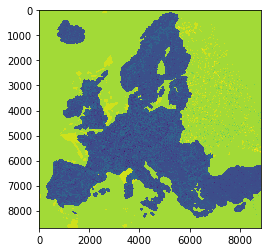

creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


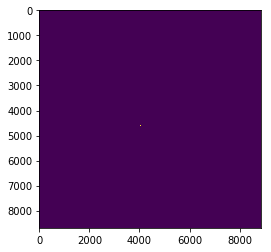

Corine
converting raster to array...
elevation
converting raster to array...
grid
converting raster to array...
population
converting raster to array...
protected
converting raster to array...
rails
converting raster to array...
river
converting raster to array...
roads
converting raster to array...
slope
converting raster to array...
sea
converting raster to array...
[[13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 ...
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]]
converting array to raster...


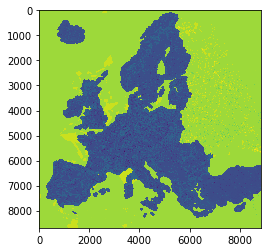

creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


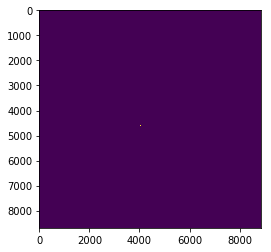

Corine
converting raster to array...
elevation
converting raster to array...
grid
converting raster to array...
population
converting raster to array...
protected
converting raster to array...
rails
converting raster to array...
river
converting raster to array...
roads
converting raster to array...
slope
converting raster to array...
sea
converting raster to array...
[[13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 ...
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]]
converting array to raster...


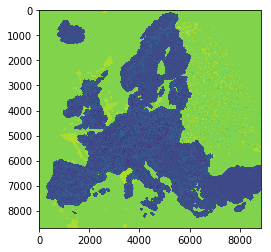

creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


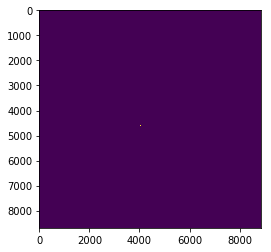

Corine
converting raster to array...
elevation
converting raster to array...
grid
converting raster to array...
population
converting raster to array...
protected
converting raster to array...
rails
converting raster to array...
river
converting raster to array...
roads
converting raster to array...
slope
converting raster to array...
sea
converting raster to array...
[[13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 ...
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]]
converting array to raster...


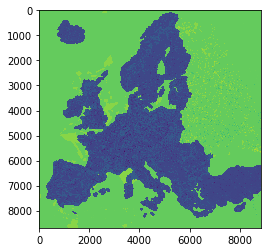

creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


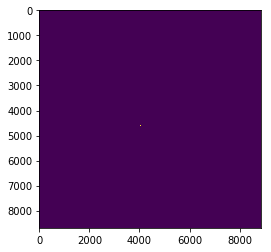

Corine
converting raster to array...
elevation
converting raster to array...
grid
converting raster to array...
population
converting raster to array...
protected
converting raster to array...
rails
converting raster to array...
river
converting raster to array...
roads
converting raster to array...
slope
converting raster to array...
sea
converting raster to array...
[[13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 ...
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]]
converting array to raster...


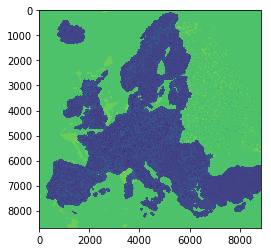

creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


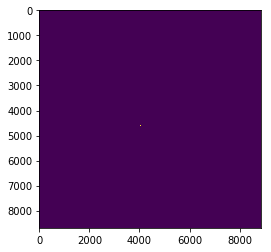

Corine
converting raster to array...
elevation
converting raster to array...
grid
converting raster to array...
population
converting raster to array...
protected
converting raster to array...
rails
converting raster to array...
river
converting raster to array...
roads
converting raster to array...
slope
converting raster to array...
sea
converting raster to array...
[[13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 ...
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]]
converting array to raster...


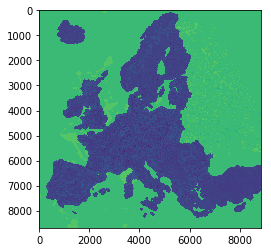

creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


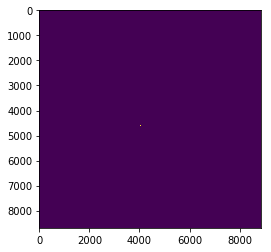

Corine
converting raster to array...
elevation
converting raster to array...
grid
converting raster to array...
population
converting raster to array...
protected
converting raster to array...
rails
converting raster to array...
river
converting raster to array...
roads
converting raster to array...
slope
converting raster to array...
sea
converting raster to array...
[[13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 ...
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]]
converting array to raster...


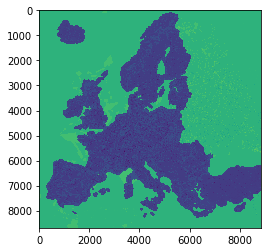

creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...


MemoryError: 

In [32]:
for popWeight in range(1,11,1):
    factorWeights = [
                1,#corine
                1,#elevation
                1,#grid
                popWeight,#population
                1,#protected
                1,#rails
                1,#river
                1,#roads
                1,#slope
                10#deepsea
                ]
    totCost, totrasprop = createTotalCostRaster(factorPathList=factorPaths,
                     weightList = factorWeights,
                     rasProp = rasProp,
                     rasterName=str(outFolder+'\\totalCost_varPop.tif'))
    path = createPath(totCostProp, totCost,strDC5, endDC5)
    array2raster(path, rasProp=totCostProp, newRasterfn=str(outFolder+
                                                            str('\\path_DC5_popW_'+str(popWeight)+'.tif')))

In [13]:
outFolder = os.path.abspath('01_Data500\out')

In [ ]:
raster2array(rasterfn=os.p)

Corine
converting raster to array...
Corine
converting raster to array...


C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


elevation
converting raster to array...
grid
converting raster to array...
population
converting raster to array...
protected
converting raster to array...
rails
converting raster to array...
river
converting raster to array...
roads
converting raster to array...
slope
converting raster to array...
[[13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 ...
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]
 [13. 13. 13. ... 13. 13. 13.]]
converting array to raster...


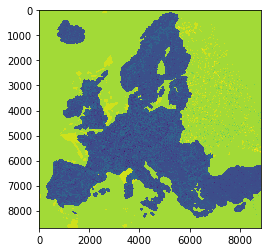

Wall time: 1min 22s


In [14]:
%%time
rasProp = RasterProp(factorPaths[0])
totCost, totrasprop = createTotalCostRaster(factorPathList=factorPaths,
                     weightList = factorWeights,
                     rasProp = rasProp,
                     rasterName=str(outFolder+'\\totalCost.tif'))

In [109]:
len(np.unique(totCost))

10706788

In [18]:
totCostProp = RasterProp(rasterFile=str(outFolder+'\\totalCost.tif'))
totCost     = raster2array(rasterfn=str(outFolder+'\\totalCost.tif'))

C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:62: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
C:\Users\Kumar\Anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


converting raster to array...


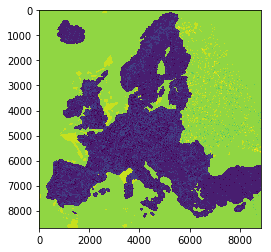

In [19]:
plt.imshow(totCost)

In [48]:
print(coord2pixelOffset(totrasprop, strDC1[0], strDC1[1]))
print(coord2pixelOffset(totrasprop, endDC1[0], endDC1[1]))

NameError: name 'totrasprop' is not defined

converting raster to array...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


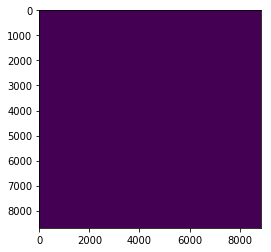

Wall time: 14.3 s


In [28]:
%%time
totCostProp = RasterProp(rasterFile=str(outFolder+'\\totalCost.tif'))
totCost     = raster2array(rasterfn=str(outFolder+'\\totalCost.tif'))
path = createPath(totCostProp, totCost,strDC5, endDC5)
array2raster(path, rasProp=totCostProp, newRasterfn=str(outFolder+'\\path_DC5.tif'))

converting array to raster...


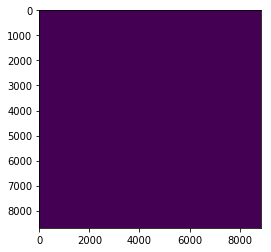

In [24]:
array2raster(path, rasProp=totCostProp, newRasterfn=str(outFolder+'\\DC1.tif'))

converting raster to array...
converting array to raster...


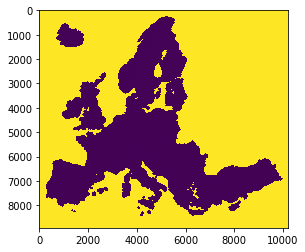

cost found
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


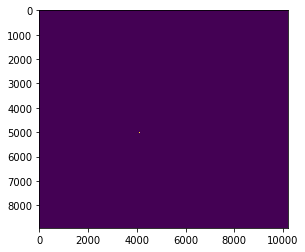

Wall time: 1min 22s


In [10]:
%%time

#edgetest
#strCor =(2493927,8125103)

#horizontaltest
#endCor =(3142713,4453448)
#strCor =(4721446,5859353)
#ham-to-rome
strCor = (4371947.0, 5991230.0)
endCor = (4548122.0, 4617160.0)

factorPaths= [os.path.abspath('Data/corine_500_gk4.tif')]
corProp = RasterProp(os.path.abspath('Data/corine_500_gk4.tif'))
factorWeights = [1]
costFile = os.path.abspath('Data/output/corine_500.tif')
pathFile = os.path.abspath('Data/output/corine_500_path.tif')
finalCostPath, sliceRasProp = createTotalCostRaster(factorPathList=factorPaths,
                                                     weightList=factorWeights,
                                                     rasProp=corProp,
                                                     rasterName=costFile,
                                                     slicing=False,
                                                     strPoint=strCor,
                                                     endPoint=endCor)

print('cost found')
path = createPath(rasProp=sliceRasProp, 
                  costSurfaceArray=finalCostPath, 
                  startCoord=strCor, stopCoord=endCor)
array2raster(array=path, rasProp=sliceRasProp, newRasterfn=pathFile)

In [162]:
corProp.geotransform

(2467098.37555, 1000.0, 0.0, 8162147.5437, 0.0, -1000.0)

In [213]:
strCor =(2493927,8125103)
sliceObj = Slicing(corProp, strPoint=strCor, endPoint=endCor)
print(sliceObj.strPix, sliceObj.endPix)
raster = gdal.Open(corineFile)
band   = raster.GetRasterBand(1)
x_ori_rel , y_ori_rel, xlen, ylen = sliceObj.relevantArea()

array = band.ReadAsArray(xoff=x_ori_rel, 
                          yoff=y_ori_rel,
                          win_xsize=xlen,
                          win_ysize=ylen
                         )

coordinate to pixel offsetting...
coordinate to pixel offsetting...
(72, -8) (1369, 7335)
relevant area slice:x_ori,x_width,y_orig,y_width 0 1685 0 -4360


ValueError: negative dimensions are not allowed

In [146]:
factorPaths = [os.path.abspath('Data/corine.tif'),
               os.path.abspath('Data/elevation.tif')]
factorWeights = [1,1]


In [211]:
%%time
def createTotalCostRaster(factorPathList, weightList, rasProp,
                          rasterName, 
                          slicing=False, 
                          strPoint=None, 
                          endPoint=None):
    
    if not slicing:
        costArray = maxMinScale(raster2array(factorPathList[0]))*weightList[0]
        for fpos in range(1,len(factorPathList)):
            factorArray = maxMinScale(raster2array(factorPathList[fpos]))*weightList[fpos]
            costArray = np.add(costArray, factorArray)
        np.place(costArray, costArray==0,100)
        array2raster(costArray, rasProp, rasterName)
        return costArray, rasProp
    
    
    else:
        sliceObj = Slicing(rasProp, strPoint, endPoint)
        raster = gdal.Open(factorPathList[0])
        band   = raster.GetRasterBand(1)
        
        x_ori_rel , y_ori_rel, xlen, ylen = sliceObj.relevantArea()
        
        sliceRasProp = RasterProp(factorPathList[0],
                                  slicing   = True, 
                                  sliceClass= sliceObj)
        
        array = band.ReadAsArray(xoff=x_ori_rel, 
                          yoff=y_ori_rel,
                          win_xsize=xlen,
                          win_ysize=ylen
                         )
        
        costArray = maxMinScale(array)*weightList[0]
        
        for fpos in range(1, len(factorPathList)):
            raster = gdal.Open(factorPathList[fpos])
            band   = raster.GetRasterBand(1)
            factorArray = maxMinScale(band.ReadAsArray(xoff=x_ori_rel, 
                          yoff=y_ori_rel,
                          win_xsize=xlen,
                          win_ysize=ylen
                         ))*weightList[fpos]
            print(np.shape(costArray), np.shape(factorArray))
            costArray = np.add(costArray, factorArray)
        
        np.place(costArray, costArray==0,100)
        array2raster(costArray, sliceRasProp, rasterName)
        plt.imshow(costArray)
        return costArray, sliceRasProp
        


Wall time: 0 ns


In [151]:
sliceTest = Slicing(corProp, strPoint=strCor, endPoint=endCor)

coordinate to pixel offsetting...
coordinate to pixel offsetting...


In [150]:
np.shape(raster2array(corineFile))

converting raster to array...


(4211, 5003)

# Input Rasters

In [12]:
import os

Reading Rasters and covert to array

In [13]:
cor2A = raster2array(os.path.abspath('Data/corine.tif'))
elevA = raster2array(os.path.abspath('Data/elevation.tif'))
popuA = raster2array(os.path.abspath('Data/population.tif'))
riveA = raster2array(os.path.abspath('Data/river.tif'))
roadA = raster2array(os.path.abspath('Data/road.tif'))
slopA = raster2array(os.path.abspath('Data/slope.tif'))

In [42]:
corProp = RasterProp(os.path.abspath('Data/corine.tif'))

# run on full file

In [61]:
file1 = 'data_test/100m_small.tif'
file2 = 'data_test/250m_small.tif'
file3 = 'data_test/500m_small.tif'
file4 = 'data_test/1000m_small.tif'

In [18]:
corProp.originX

2467098.37555

In [131]:
corProp.originY

8162147.5437

In [67]:
# hambur to rome
strCor = (4363309.0,5526274.0)
endCor = (4365417.0,5442487.0)
#file = 'data_test/corine_250_gk4.tif'
corProp = RasterProp(os.path.abspath(file4))
costSurfArray = maxMinScale(raster2array(os.path.abspath(file4)))
np.place(costSurfArray, costSurfArray==0,100)
path = createPath(corProp, costSurfArray, strCor, endCor)
array2raster(path, corProp, os.path.abspath('data_test/cor_1000.tif'))

converting raster to array...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


In [49]:
corineFile = os.path.abspath('Data/corine.tif')

In [45]:
# hambur to rome
strCor = (4361527.0, 5974975.0)
endCor = (4544250.0, 4631609.0)
corProp = RasterProp(os.path.abspath('Data/corine.tif'))

In [55]:
sliceTest = Slicing(corProp,strCor,endCor)
x_ori_rel , y_ori_rel, xlen, ylen = sliceTest.relevantArea()

coordinate to pixel offsetting...
coordinate to pixel offsetting...


In [59]:
print(x_ori_rel , y_ori_rel, xlen, ylen)

1528 1343 732 2686


In [47]:
pixel2coord(corProp,1528,1343)

(3995598, 6818647)

In [48]:
coord2pixelOffset(corProp,pixel2coord(corProp,1528,1343)[0],
                 pixel2coord(corProp, 1528,1343)[1])

coordinate to pixel offsetting...


(1528, 1343)

In [53]:
np.shape(raster2array(corineFile))

converting raster to array...


(4211, 5003)

In [54]:
raster = gdal.Open(os.path.abspath('Data/corine.tif'))
band   = raster.GetRasterBand(1)
#corProp = RasterProp(os.path.abspath('Data/corine.tif'))

In [57]:
array  = band.ReadAsArray(xoff=x_ori_rel, 
                          yoff=y_ori_rel,
                          win_xsize=xlen,
                          win_ysize=ylen
                         )

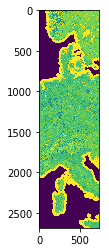

In [60]:
plt.imshow(array)

In [62]:
corProp.originX

2467098.37555

In [58]:
np.shape(array)

(2686, 732)

In [9]:
#strCor = (4361528.0,5974975.0)
#endCor = (4544250.0,5631609.0)

In [43]:
strPix = coord2pixelOffset(corProp, strCor[0], strCor[1])
endPix = coord2pixelOffset(corProp, endCor[0], endCor[1])

coordinate to pixel offsetting...
coordinate to pixel offsetting...


In [19]:
def strLineDistance(strPoint,endPoint):
    return int(math.sqrt((strPoint[0]-endPoint[0])**2+((strPoint[1]-endPoint[1])**2)))
#strLineDistance(strPix,endPix)

1355

(1528, 1343, 732, 2686)

In [55]:
x_ori_rel , y_ori_rel, xlen, ylen = relevantArea(
                                                strPoint=strPix, endPoint=endPix)
print(x_ori_rel,y_ori_rel, xlen, ylen)

1528 1343 732 2686


In [98]:
array  = band.ReadAsArray(xoff=x_ori_rel, 
                          yoff=y_ori_rel,
                          win_xsize=xlen,
                          win_ysize=ylen
                         )
np.place(array, array==0,100)
array2raster(array = array, rasProp= corProp, 
             newRasterfn='selectionTest.tif')

path = createPath(rasProp=corProp, costSurfaceArray=array,
                  startCoord = strCor, stopCoord=endCor)
pd.DataFrame(path).to_csv('selectionPath.csv')
array2raster(array=path, rasProp=corProp, 
            newRasterfn='selectionPath.tif')

converting array to raster...
creating path...
coordinate to pixel offsetting...
coordinate to pixel offsetting...
path created...
converting array to raster...


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [17]:
cor2A_s = maxMinScale(cor2A)
roadA_s = maxMinScale(roadA)
slopA_s = maxMinScale(roadA)
elevA_s = maxMinScale(elevA)
riveA_s = maxMinScale(riveA)
popuA_s = maxMinScale(popuA)

Raster Proproperties

In [18]:
allCostArrays = [cor2A_s, roadA_s,
                 slopA_s, elevA_s, 
                 popuA_s, riveA_s]

In [19]:
def shapeTest(arrayList):
    for array in arrayList:
        print(np.shape(array))

In [20]:
shapeTest(allCostArrays)

(4211, 5003)
(4211, 5003)
(4211, 5003)
(4211, 5003)
(4211, 5003)
(4211, 5003)


## Combine Raster with weights

In [21]:
def getCombinedArray(rasArrayList, wlist):
    wt =np.array([x/sum(wlist) for x in wlist])
    finalArray = rasArrayList[0]*wt[0]
    for rasNum in range(1,len(wlist),1):
        finalArray = np.add(finalArray,rasArrayList[rasNum]*wt[rasNum])
    return finalArray

#finalCostArray = getCombinedArray([landCostArray,landCostArray2],[3,4])

In [22]:
cost = getCombinedArray([cor2A_s, roadA_s,
                         slopA_s, elevA_s, 
                         popuA_s, riveA_s],
                        [1,5,
                         1,1,
                         3,1])
np.place(cost, cost==0,100)

In [23]:
path = createPath(rasProp, cost,
                strCor,endCor)

In [24]:
array2raster(path, rasProp, 'test_HH_RO_6param_3Pop_5Road.tif')